# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-undersampled-besra'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/netifier/undersampled.csv', encoding='latin-1')
data.shape

(5798, 5)

In [7]:
data.head()

,processed_text,pornografi,sara,radikalisme,pencemaran_nama_baik
0,sidangahok semoga sipenista agama dan ateknya ...,0,1,1,1
1,itu membuktikan bahwa rakyat malaysia anti cin...,0,1,0,1
2,eh memek diam kamu kepala kamu kaya kontol muk...,1,0,0,0
3,font fira sans some pakistanis dan indian musl...,0,1,1,0
4,pngusiran syiah kok jadi mirip sama di usir ny...,0,0,1,0


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(4638,) (4638, 4)
(1160,) (1160, 4)


# BUILD DATASET & DATALOADERS

In [9]:
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [10]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = NetifierDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))
    
    accelerator.wait_for_everyone()    
    if accelerator.is_local_main_process:
        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)

        target_samples = math.ceil(0.1 * len(X_pool))
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(score_changes)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)
    
            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}-{percentage}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6444, Accuracy: 0.728, F1 Micro: 0.0279, F1 Macro: 0.0291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5528, Accuracy: 0.7313, F1 Micro: 0.0508, F1 Macro: 0.051
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5179, Accuracy: 0.7516, F1 Micro: 0.1816, F1 Macro: 0.1523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4528, Accuracy: 0.7802, F1 Micro: 0.3626, F1 Macro: 0.2911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.424, Accuracy: 0.7987, F1 Micro: 0.5296, F1 Macro: 0.4727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3869, Accuracy: 0.8055, F1 Micro: 0.5968, F1 Macro: 0.5733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3361, Accuracy: 0.8092, F1 Micro: 0.6031, F1 Macro: 0.5816
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3031, Accuracy: 0.8183, F1 Micro: 0.6273, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.602, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5405, Accuracy: 0.7387, F1 Micro: 0.1005, F1 Macro: 0.0937
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4942, Accuracy: 0.7603, F1 Micro: 0.2438, F1 Macro: 0.1859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4231, Accuracy: 0.7917, F1 Micro: 0.4654, F1 Macro: 0.379
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3903, Accuracy: 0.8061, F1 Micro: 0.5766, F1 Macro: 0.5377
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3508, Accuracy: 0.8119, F1 Micro: 0.5985, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2999, Accuracy: 0.8183, F1 Micro: 0.6323, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2692, Accuracy: 0.8259, F1 Micro: 0.6561, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2425, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6211, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5592, Accuracy: 0.7268, F1 Micro: 0.0192, F1 Macro: 0.0202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5179, Accuracy: 0.7553, F1 Micro: 0.2098, F1 Macro: 0.1721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4469, Accuracy: 0.7868, F1 Micro: 0.4416, F1 Macro: 0.3902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.413, Accuracy: 0.803, F1 Micro: 0.5838, F1 Macro: 0.5641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3666, Accuracy: 0.8047, F1 Micro: 0.6154, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3182, Accuracy: 0.815, F1 Micro: 0.642, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2846, Accuracy: 0.8226, F1 Micro: 0.6453, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2637, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5932, Accuracy: 0.7309, F1 Micro: 0.048, F1 Macro: 0.0484
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4897, Accuracy: 0.7998, F1 Micro: 0.512, F1 Macro: 0.4478
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4082, Accuracy: 0.8236, F1 Micro: 0.6364, F1 Macro: 0.6045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3366, Accuracy: 0.8421, F1 Micro: 0.7108, F1 Macro: 0.7125
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2936, Accuracy: 0.8592, F1 Micro: 0.7296, F1 Macro: 0.7296
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2542, Accuracy: 0.8657, F1 Micro: 0.7418, F1 Macro: 0.7383
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1949, Accuracy: 0.8711, F1 Micro: 0.7653, F1 Macro: 0.7695
Epoch 8/10, Train Loss: 0.1695, Accuracy: 0.868, F1 Micro: 0.7377, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1442, Accuracy: 0.876, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5767, Accuracy: 0.7428, F1 Micro: 0.127, F1 Macro: 0.114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4668, Accuracy: 0.8104, F1 Micro: 0.5832, F1 Macro: 0.5373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3807, Accuracy: 0.8345, F1 Micro: 0.6729, F1 Macro: 0.6606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3041, Accuracy: 0.8448, F1 Micro: 0.7178, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2704, Accuracy: 0.8627, F1 Micro: 0.7431, F1 Macro: 0.7463
Epoch 6/10, Train Loss: 0.2381, Accuracy: 0.8635, F1 Micro: 0.738, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1727, Accuracy: 0.8719, F1 Micro: 0.765, F1 Macro: 0.769
Epoch 8/10, Train Loss: 0.1449, Accuracy: 0.8643, F1 Micro: 0.7293, F1 Macro: 0.7277
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1274, Accuracy: 0.8723, F1 Micro: 0.7704, F1 Macro: 0.7755
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5994, Accuracy: 0.7255, F1 Micro: 0.0104, F1 Macro: 0.0111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5022, Accuracy: 0.801, F1 Micro: 0.5576, F1 Macro: 0.5202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4103, Accuracy: 0.8215, F1 Micro: 0.641, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3304, Accuracy: 0.8433, F1 Micro: 0.7188, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.287, Accuracy: 0.8614, F1 Micro: 0.7431, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2512, Accuracy: 0.8686, F1 Micro: 0.7471, F1 Macro: 0.7436
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1834, Accuracy: 0.8705, F1 Micro: 0.7621, F1 Macro: 0.763
Epoch 8/10, Train Loss: 0.1611, Accuracy: 0.8711, F1 Micro: 0.7544, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.137, Accuracy: 0.8734, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5859, Accuracy: 0.7701, F1 Micro: 0.296, F1 Macro: 0.2403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4353, Accuracy: 0.8252, F1 Micro: 0.6386, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3475, Accuracy: 0.8577, F1 Micro: 0.7431, F1 Macro: 0.7495
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2807, Accuracy: 0.8694, F1 Micro: 0.7682, F1 Macro: 0.7741
Epoch 5/10, Train Loss: 0.2301, Accuracy: 0.8756, F1 Micro: 0.7558, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1953, Accuracy: 0.8816, F1 Micro: 0.7773, F1 Macro: 0.7788
Epoch 7/10, Train Loss: 0.1572, Accuracy: 0.8775, F1 Micro: 0.7639, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1174, Accuracy: 0.8781, F1 Micro: 0.78, F1 Macro: 0.785
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1067, Accuracy: 0.8781, F1 Micro: 0.7852, F1 Macro: 0.7917
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5568, Accuracy: 0.7889, F1 Micro: 0.4181, F1 Macro: 0.3627
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4116, Accuracy: 0.8403, F1 Micro: 0.6737, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3228, Accuracy: 0.8643, F1 Micro: 0.7621, F1 Macro: 0.7681
Epoch 4/10, Train Loss: 0.2638, Accuracy: 0.8697, F1 Micro: 0.762, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2156, Accuracy: 0.8847, F1 Micro: 0.783, F1 Macro: 0.7869
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1797, Accuracy: 0.884, F1 Micro: 0.7839, F1 Macro: 0.7864
Epoch 7/10, Train Loss: 0.1399, Accuracy: 0.8754, F1 Micro: 0.7603, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.107, Accuracy: 0.8791, F1 Micro: 0.7889, F1 Macro: 0.7946
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.8836, F1 Micro: 0.785, F1 Macro: 0.7878
Epoch 10/10, Train Loss: 0.0671, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5857, Accuracy: 0.7712, F1 Micro: 0.341, F1 Macro: 0.2936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4386, Accuracy: 0.8218, F1 Micro: 0.6371, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3444, Accuracy: 0.8555, F1 Micro: 0.749, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.278, Accuracy: 0.8703, F1 Micro: 0.7691, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2298, Accuracy: 0.8779, F1 Micro: 0.7694, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1935, Accuracy: 0.8816, F1 Micro: 0.7841, F1 Macro: 0.7876
Epoch 7/10, Train Loss: 0.1475, Accuracy: 0.8758, F1 Micro: 0.7702, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1166, Accuracy: 0.8787, F1 Micro: 0.7868, F1 Macro: 0.7932
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.095, Accuracy: 0.8777, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.548, Accuracy: 0.8065, F1 Micro: 0.55, F1 Macro: 0.5106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3823, Accuracy: 0.8454, F1 Micro: 0.6803, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3058, Accuracy: 0.8657, F1 Micro: 0.7381, F1 Macro: 0.7382
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2569, Accuracy: 0.8828, F1 Micro: 0.7791, F1 Macro: 0.7804
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2108, Accuracy: 0.8865, F1 Micro: 0.7906, F1 Macro: 0.7934
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1564, Accuracy: 0.8865, F1 Micro: 0.7914, F1 Macro: 0.7942
Epoch 7/10, Train Loss: 0.1264, Accuracy: 0.8845, F1 Micro: 0.7825, F1 Macro: 0.7843
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.882, F1 Micro: 0.7899, F1 Macro: 0.7941
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.8838, F1 Micro: 0.7857, F1 Macro: 0.7891
Epoch 10/10, Train Loss: 0.071, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5259, Accuracy: 0.8098, F1 Micro: 0.5643, F1 Macro: 0.5173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3649, Accuracy: 0.8567, F1 Micro: 0.722, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2937, Accuracy: 0.8713, F1 Micro: 0.7568, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2421, Accuracy: 0.8849, F1 Micro: 0.779, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1944, Accuracy: 0.882, F1 Micro: 0.7812, F1 Macro: 0.7825
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1449, Accuracy: 0.8836, F1 Micro: 0.788, F1 Macro: 0.791
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.8824, F1 Micro: 0.7755, F1 Macro: 0.7776
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.8803, F1 Micro: 0.7865, F1 Macro: 0.79
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.8849, F1 Micro: 0.7853, F1 Macro: 0.7872
Epoch 10/10, Train Loss: 0.0603, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5585, Accuracy: 0.7917, F1 Micro: 0.5547, F1 Macro: 0.5249
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3947, Accuracy: 0.8433, F1 Micro: 0.6882, F1 Macro: 0.6796
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3076, Accuracy: 0.8662, F1 Micro: 0.7493, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2507, Accuracy: 0.8843, F1 Micro: 0.7875, F1 Macro: 0.7913
Epoch 5/10, Train Loss: 0.2054, Accuracy: 0.8843, F1 Micro: 0.787, F1 Macro: 0.7878
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1553, Accuracy: 0.8834, F1 Micro: 0.7921, F1 Macro: 0.7969
Epoch 7/10, Train Loss: 0.1271, Accuracy: 0.8843, F1 Micro: 0.7796, F1 Macro: 0.7813
Epoch 8/10, Train Loss: 0.1051, Accuracy: 0.881, F1 Micro: 0.7894, F1 Macro: 0.7944
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.8824, F1 Micro: 0.788, F1 Macro: 0.7922
Epoch 10/10, Train Loss: 0.0626, Accuracy: 0.8849, F1 Micro: 0.7876, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5402, Accuracy: 0.8102, F1 Micro: 0.5806, F1 Macro: 0.5371
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.369, Accuracy: 0.8674, F1 Micro: 0.7539, F1 Macro: 0.7574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2793, Accuracy: 0.8795, F1 Micro: 0.7855, F1 Macro: 0.7907
Epoch 4/10, Train Loss: 0.2342, Accuracy: 0.8828, F1 Micro: 0.7804, F1 Macro: 0.779
Epoch 5/10, Train Loss: 0.1831, Accuracy: 0.8843, F1 Micro: 0.7844, F1 Macro: 0.7857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1491, Accuracy: 0.883, F1 Micro: 0.795, F1 Macro: 0.7994
Epoch 7/10, Train Loss: 0.1177, Accuracy: 0.8834, F1 Micro: 0.7937, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.8832, F1 Micro: 0.7819, F1 Macro: 0.782
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.8867, F1 Micro: 0.7987, F1 Macro: 0.8029
Epoch 10/10, Train Loss: 0.053, Accuracy: 0.8847, F1 Micro: 0.7931, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5181, Accuracy: 0.8137, F1 Micro: 0.5774, F1 Macro: 0.5229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3564, Accuracy: 0.868, F1 Micro: 0.7622, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2729, Accuracy: 0.882, F1 Micro: 0.7941, F1 Macro: 0.7994
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2238, Accuracy: 0.889, F1 Micro: 0.7947, F1 Macro: 0.797
Epoch 5/10, Train Loss: 0.1751, Accuracy: 0.8838, F1 Micro: 0.7839, F1 Macro: 0.786
Epoch 6/10, Train Loss: 0.1427, Accuracy: 0.8877, F1 Micro: 0.7908, F1 Macro: 0.7917
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.8892, F1 Micro: 0.8, F1 Macro: 0.804
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.8869, F1 Micro: 0.791, F1 Macro: 0.7916
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.8884, F1 Micro: 0.7981, F1 Macro: 0.8011
Epoch 10/10, Train Loss: 0.0457, Accuracy: 0.889, F1 Micro: 0.7879, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5426, Accuracy: 0.8111, F1 Micro: 0.6068, F1 Macro: 0.5822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3653, Accuracy: 0.8627, F1 Micro: 0.7526, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2789, Accuracy: 0.8764, F1 Micro: 0.7854, F1 Macro: 0.7907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2337, Accuracy: 0.8863, F1 Micro: 0.7884, F1 Macro: 0.7889
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.8863, F1 Micro: 0.79, F1 Macro: 0.7917
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1445, Accuracy: 0.8855, F1 Micro: 0.7999, F1 Macro: 0.8047
Epoch 7/10, Train Loss: 0.1131, Accuracy: 0.8863, F1 Micro: 0.7922, F1 Macro: 0.796
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.8845, F1 Micro: 0.7986, F1 Macro: 0.8033
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.8845, F1 Micro: 0.8, F1 Macro: 0.805
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5159, Accuracy: 0.8185, F1 Micro: 0.6182, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3439, Accuracy: 0.8678, F1 Micro: 0.7767, F1 Macro: 0.7842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2794, Accuracy: 0.8853, F1 Micro: 0.7944, F1 Macro: 0.7989
Epoch 4/10, Train Loss: 0.2186, Accuracy: 0.8826, F1 Micro: 0.7938, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1821, Accuracy: 0.8888, F1 Micro: 0.8052, F1 Macro: 0.8099
Epoch 6/10, Train Loss: 0.1425, Accuracy: 0.8824, F1 Micro: 0.8025, F1 Macro: 0.8088
Epoch 7/10, Train Loss: 0.0957, Accuracy: 0.8873, F1 Micro: 0.8003, F1 Macro: 0.8022
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.8888, F1 Micro: 0.8049, F1 Macro: 0.8096
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.8869, F1 Micro: 0.7914, F1 Macro: 0.7941
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0.89, F1 Micro: 0.7996, F1 Macro: 0.8022
Model 1 - Iteration 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4979, Accuracy: 0.824, F1 Micro: 0.6294, F1 Macro: 0.6091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3313, Accuracy: 0.8756, F1 Micro: 0.7857, F1 Macro: 0.7928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2646, Accuracy: 0.8888, F1 Micro: 0.7967, F1 Macro: 0.8002
Epoch 4/10, Train Loss: 0.2078, Accuracy: 0.8867, F1 Micro: 0.7948, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.8832, F1 Micro: 0.7983, F1 Macro: 0.8031
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.8867, F1 Micro: 0.8065, F1 Macro: 0.8123
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.8898, F1 Micro: 0.8042, F1 Macro: 0.8083
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.8886, F1 Micro: 0.8033, F1 Macro: 0.8083
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.8912, F1 Micro: 0.8022, F1 Macro: 0.805
Epoch 10/10, Train Loss: 0.0464, Accuracy: 0.8892, F1 Micro: 0.8003, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5174, Accuracy: 0.8203, F1 Micro: 0.6193, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.341, Accuracy: 0.8692, F1 Micro: 0.7733, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2734, Accuracy: 0.8834, F1 Micro: 0.7882, F1 Macro: 0.7919
Epoch 4/10, Train Loss: 0.2143, Accuracy: 0.8849, F1 Micro: 0.7856, F1 Macro: 0.7859
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.8836, F1 Micro: 0.7965, F1 Macro: 0.801
Epoch 6/10, Train Loss: 0.1318, Accuracy: 0.8783, F1 Micro: 0.7953, F1 Macro: 0.8014
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.8921, F1 Micro: 0.813, F1 Macro: 0.8183
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.8869, F1 Micro: 0.7907, F1 Macro: 0.7937
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.8884, F1 Micro: 0.7912, F1 Macro: 0.7925
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.8882, F1 Micro: 0.7914, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5147, Accuracy: 0.8316, F1 Micro: 0.6563, F1 Macro: 0.6378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3444, Accuracy: 0.8713, F1 Micro: 0.7645, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2517, Accuracy: 0.8769, F1 Micro: 0.7909, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2127, Accuracy: 0.8894, F1 Micro: 0.792, F1 Macro: 0.7932
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.8912, F1 Micro: 0.8063, F1 Macro: 0.8093
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.8906, F1 Micro: 0.7977, F1 Macro: 0.8
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.8869, F1 Micro: 0.8081, F1 Macro: 0.8139
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.89, F1 Micro: 0.8071, F1 Macro: 0.8098
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.8886, F1 Micro: 0.7909, F1 Macro: 0.7918
Epoch 10/10, Train Loss: 0.041, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4959, Accuracy: 0.839, F1 Micro: 0.6752, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3291, Accuracy: 0.876, F1 Micro: 0.7751, F1 Macro: 0.7778
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2419, Accuracy: 0.8855, F1 Micro: 0.8021, F1 Macro: 0.8076
Epoch 4/10, Train Loss: 0.1964, Accuracy: 0.8884, F1 Micro: 0.7895, F1 Macro: 0.7907
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.889, F1 Micro: 0.8076, F1 Macro: 0.8114
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.8935, F1 Micro: 0.8021, F1 Macro: 0.8046
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.8828, F1 Micro: 0.8047, F1 Macro: 0.8113
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.8884, F1 Micro: 0.8033, F1 Macro: 0.8058
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.8921, F1 Micro: 0.8085, F1 Macro: 0.8121
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0374, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5222, Accuracy: 0.8287, F1 Micro: 0.6525, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.343, Accuracy: 0.8773, F1 Micro: 0.7781, F1 Macro: 0.7805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2481, Accuracy: 0.8808, F1 Micro: 0.7963, F1 Macro: 0.8026
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2088, Accuracy: 0.8912, F1 Micro: 0.8006, F1 Macro: 0.8007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1761, Accuracy: 0.8931, F1 Micro: 0.8052, F1 Macro: 0.8061
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.8888, F1 Micro: 0.7931, F1 Macro: 0.7947
Epoch 7/10, Train Loss: 0.0897, Accuracy: 0.8851, F1 Micro: 0.8043, F1 Macro: 0.8107
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.8902, F1 Micro: 0.8068, F1 Macro: 0.8099
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.8949, F1 Micro: 0.8085, F1 Macro: 0.8109
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4912, Accuracy: 0.8308, F1 Micro: 0.6796, F1 Macro: 0.6609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3203, Accuracy: 0.874, F1 Micro: 0.7555, F1 Macro: 0.7538
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2574, Accuracy: 0.8865, F1 Micro: 0.8049, F1 Macro: 0.8106
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2206, Accuracy: 0.8919, F1 Micro: 0.8068, F1 Macro: 0.8097
Epoch 5/10, Train Loss: 0.1701, Accuracy: 0.8904, F1 Micro: 0.8045, F1 Macro: 0.8087
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.8937, F1 Micro: 0.8082, F1 Macro: 0.8123
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.8929, F1 Micro: 0.8077, F1 Macro: 0.8081
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.8888, F1 Micro: 0.8089, F1 Macro: 0.8137
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.8914, F1 Micro: 0.8109, F1 Macro: 0.8158
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.467, Accuracy: 0.845, F1 Micro: 0.7029, F1 Macro: 0.6927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3084, Accuracy: 0.8785, F1 Micro: 0.7757, F1 Macro: 0.7783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2498, Accuracy: 0.8855, F1 Micro: 0.795, F1 Macro: 0.7997
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2069, Accuracy: 0.8912, F1 Micro: 0.811, F1 Macro: 0.8152
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.8931, F1 Micro: 0.8058, F1 Macro: 0.8097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.8951, F1 Micro: 0.8122, F1 Macro: 0.817
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.89, F1 Micro: 0.8071, F1 Macro: 0.8091
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.8933, F1 Micro: 0.8164, F1 Macro: 0.8213
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.8917, F1 Micro: 0.8066, F1 Macro: 0.8106
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4894, Accuracy: 0.845, F1 Micro: 0.7107, F1 Macro: 0.7112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3174, Accuracy: 0.8752, F1 Micro: 0.7588, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2548, Accuracy: 0.8845, F1 Micro: 0.7999, F1 Macro: 0.8053
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.213, Accuracy: 0.8902, F1 Micro: 0.8078, F1 Macro: 0.8128
Epoch 5/10, Train Loss: 0.1683, Accuracy: 0.8941, F1 Micro: 0.8054, F1 Macro: 0.8079
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.8919, F1 Micro: 0.8129, F1 Macro: 0.8168
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.8933, F1 Micro: 0.8084, F1 Macro: 0.8094
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.8917, F1 Micro: 0.8101, F1 Macro: 0.8134
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.8912, F1 Micro: 0.8047, F1 Macro: 0.806
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0392, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4834, Accuracy: 0.8483, F1 Micro: 0.6938, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3216, Accuracy: 0.8795, F1 Micro: 0.7857, F1 Macro: 0.7909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2486, Accuracy: 0.889, F1 Micro: 0.7996, F1 Macro: 0.802
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.204, Accuracy: 0.8951, F1 Micro: 0.8065, F1 Macro: 0.8085
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.8964, F1 Micro: 0.8121, F1 Macro: 0.8148
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.8949, F1 Micro: 0.8087, F1 Macro: 0.812
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.8927, F1 Micro: 0.8051, F1 Macro: 0.8084
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.891, F1 Micro: 0.8037, F1 Macro: 0.8064
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.8964, F1 Micro: 0.8144, F1 Macro: 0.8177
Epoch 10/10, Train Loss: 0.0378, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4701, Accuracy: 0.8501, F1 Micro: 0.7142, F1 Macro: 0.7133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3128, Accuracy: 0.8865, F1 Micro: 0.798, F1 Macro: 0.8038
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2387, Accuracy: 0.8921, F1 Micro: 0.8062, F1 Macro: 0.808
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.196, Accuracy: 0.8943, F1 Micro: 0.8113, F1 Macro: 0.8143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.8974, F1 Micro: 0.8161, F1 Macro: 0.8199
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.8935, F1 Micro: 0.8112, F1 Macro: 0.8148
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.8933, F1 Micro: 0.8066, F1 Macro: 0.8095
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.8954, F1 Micro: 0.8133, F1 Macro: 0.8159
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.896, F1 Micro: 0.8133, F1 Macro: 0.8166
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.8919, F1 Micro: 0.8018, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4916, Accuracy: 0.8493, F1 Micro: 0.7067, F1 Macro: 0.7043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3214, Accuracy: 0.8803, F1 Micro: 0.7854, F1 Macro: 0.7893
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2461, Accuracy: 0.8892, F1 Micro: 0.8049, F1 Macro: 0.808
Epoch 4/10, Train Loss: 0.1967, Accuracy: 0.8927, F1 Micro: 0.8045, F1 Macro: 0.8067
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1541, Accuracy: 0.8923, F1 Micro: 0.8093, F1 Macro: 0.8138
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.8947, F1 Micro: 0.8127, F1 Macro: 0.8158
Epoch 7/10, Train Loss: 0.0822, Accuracy: 0.8939, F1 Micro: 0.8082, F1 Macro: 0.811
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.8886, F1 Micro: 0.8086, F1 Macro: 0.8118
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.8947, F1 Micro: 0.8064, F1 Macro: 0.808
Epoch 10/10, Train Loss: 0.0364, Accuracy: 0.8962, F1 Micro: 0.8106, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4851, Accuracy: 0.8538, F1 Micro: 0.7381, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3039, Accuracy: 0.8861, F1 Micro: 0.7941, F1 Macro: 0.7983
Epoch 3/10, Train Loss: 0.2307, Accuracy: 0.889, F1 Micro: 0.7897, F1 Macro: 0.7874
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1935, Accuracy: 0.8917, F1 Micro: 0.805, F1 Macro: 0.8089
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.8958, F1 Micro: 0.8043, F1 Macro: 0.8053
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.8917, F1 Micro: 0.8093, F1 Macro: 0.8131
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.8943, F1 Micro: 0.8053, F1 Macro: 0.8061
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.8923, F1 Micro: 0.8032, F1 Macro: 0.8069
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.8966, F1 Micro: 0.8136, F1 Macro: 0.8169
Epoch 10/10, Train Loss: 0.0389, Accuracy: 0.8958, F1 Micro: 0.8109, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4749, Accuracy: 0.8637, F1 Micro: 0.7497, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2982, Accuracy: 0.8863, F1 Micro: 0.7972, F1 Macro: 0.8019
Epoch 3/10, Train Loss: 0.2238, Accuracy: 0.8902, F1 Micro: 0.7932, F1 Macro: 0.7918
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.8949, F1 Micro: 0.8065, F1 Macro: 0.8099
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.8986, F1 Micro: 0.8204, F1 Macro: 0.8226
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.898, F1 Micro: 0.8141, F1 Macro: 0.816
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.8968, F1 Micro: 0.8149, F1 Macro: 0.8172
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.8935, F1 Micro: 0.8094, F1 Macro: 0.8137
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.8949, F1 Micro: 0.8163, F1 Macro: 0.8199
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.8902, F1 Micro: 0.8076, F1 Macro: 0.8129
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4943, Accuracy: 0.8528, F1 Micro: 0.7354, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3041, Accuracy: 0.8865, F1 Micro: 0.7972, F1 Macro: 0.8013
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.8914, F1 Micro: 0.7989, F1 Macro: 0.7993
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1902, Accuracy: 0.8933, F1 Micro: 0.809, F1 Macro: 0.8128
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.8935, F1 Micro: 0.8021, F1 Macro: 0.8029
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.8956, F1 Micro: 0.8135, F1 Macro: 0.8162
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.89, F1 Micro: 0.7988, F1 Macro: 0.8005
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.8937, F1 Micro: 0.8089, F1 Macro: 0.8116
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.8949, F1 Micro: 0.8064, F1 Macro: 0.809
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0377, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4753, Accuracy: 0.8551, F1 Micro: 0.7223, F1 Macro: 0.7244
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3132, Accuracy: 0.883, F1 Micro: 0.7954, F1 Macro: 0.8008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2408, Accuracy: 0.889, F1 Micro: 0.8041, F1 Macro: 0.8087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1938, Accuracy: 0.8943, F1 Micro: 0.8092, F1 Macro: 0.8129
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.8949, F1 Micro: 0.8115, F1 Macro: 0.815
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.8964, F1 Micro: 0.8111, F1 Macro: 0.8139
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.8966, F1 Micro: 0.8104, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.8968, F1 Micro: 0.8171, F1 Macro: 0.8192
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.8968, F1 Micro: 0.8106, F1 Macro: 0.8144
Epoch 10/10, Train Loss: 0.0332, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4691, Accuracy: 0.8583, F1 Micro: 0.7293, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3058, Accuracy: 0.8838, F1 Micro: 0.7939, F1 Macro: 0.7985
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2318, Accuracy: 0.8933, F1 Micro: 0.8071, F1 Macro: 0.8114
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.8947, F1 Micro: 0.8099, F1 Macro: 0.8126
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.8945, F1 Micro: 0.8139, F1 Macro: 0.8188
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.8954, F1 Micro: 0.8091, F1 Macro: 0.8113
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9007, F1 Micro: 0.8166, F1 Macro: 0.8193
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.8949, F1 Micro: 0.8155, F1 Macro: 0.8192
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.8995, F1 Micro: 0.8169, F1 Macro: 0.8203
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4849, Accuracy: 0.8538, F1 Micro: 0.7243, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3123, Accuracy: 0.8832, F1 Micro: 0.7948, F1 Macro: 0.7996
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2382, Accuracy: 0.8933, F1 Micro: 0.8118, F1 Macro: 0.8162
Epoch 4/10, Train Loss: 0.184, Accuracy: 0.8931, F1 Micro: 0.8071, F1 Macro: 0.8104
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1471, Accuracy: 0.8939, F1 Micro: 0.8134, F1 Macro: 0.8166
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.8988, F1 Micro: 0.8159, F1 Macro: 0.8171
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.8968, F1 Micro: 0.8138, F1 Macro: 0.8161
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.8958, F1 Micro: 0.8157, F1 Macro: 0.819
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.8986, F1 Micro: 0.8146, F1 Macro: 0.8171
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.8937, F1 Micro: 0.813, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4686, Accuracy: 0.8633, F1 Micro: 0.7445, F1 Macro: 0.7482
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2958, Accuracy: 0.8789, F1 Micro: 0.7569, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.242, Accuracy: 0.891, F1 Micro: 0.803, F1 Macro: 0.8057
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.8921, F1 Micro: 0.8033, F1 Macro: 0.8048
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.8964, F1 Micro: 0.8081, F1 Macro: 0.8103
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.8964, F1 Micro: 0.8197, F1 Macro: 0.8252
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.8984, F1 Micro: 0.8188, F1 Macro: 0.8218
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.8978, F1 Micro: 0.815, F1 Macro: 0.8178
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.8993, F1 Micro: 0.8225, F1 Macro: 0.8268
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4556, Accuracy: 0.867, F1 Micro: 0.7535, F1 Macro: 0.7579
Epoch 2/10, Train Loss: 0.2867, Accuracy: 0.8756, F1 Micro: 0.7433, F1 Macro: 0.7346
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2339, Accuracy: 0.8954, F1 Micro: 0.8096, F1 Macro: 0.8133
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.8925, F1 Micro: 0.8029, F1 Macro: 0.8037
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.8984, F1 Micro: 0.8116, F1 Macro: 0.8129
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9017, F1 Micro: 0.8279, F1 Macro: 0.8319
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.8966, F1 Micro: 0.8221, F1 Macro: 0.8264
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.8982, F1 Micro: 0.8205, F1 Macro: 0.8235
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.898, F1 Micro: 0.8215, F1 Macro: 0.8252
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.897, F1 Micro: 0.8185, F1 Macro: 0.8221
Model 2 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4773, Accuracy: 0.8573, F1 Micro: 0.7343, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2934, Accuracy: 0.8769, F1 Micro: 0.7495, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2395, Accuracy: 0.8947, F1 Micro: 0.8087, F1 Macro: 0.8114
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.8958, F1 Micro: 0.812, F1 Macro: 0.814
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.8991, F1 Micro: 0.8166, F1 Macro: 0.8183
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.8945, F1 Micro: 0.8214, F1 Macro: 0.8268
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9007, F1 Micro: 0.8218, F1 Macro: 0.8249
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.8993, F1 Micro: 0.8173, F1 Macro: 0.82
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.8988, F1 Micro: 0.8191, F1 Macro: 0.8224
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4559, Accuracy: 0.8546, F1 Micro: 0.7077, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2978, Accuracy: 0.8859, F1 Micro: 0.7966, F1 Macro: 0.8012
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2314, Accuracy: 0.8919, F1 Micro: 0.7968, F1 Macro: 0.7982
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.8919, F1 Micro: 0.7904, F1 Macro: 0.789
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9001, F1 Micro: 0.8151, F1 Macro: 0.8169
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.8993, F1 Micro: 0.8099, F1 Macro: 0.8105
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.8991, F1 Micro: 0.8119, F1 Macro: 0.8138
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.8984, F1 Micro: 0.8204, F1 Macro: 0.8225
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9036, F1 Micro: 0.8279, F1 Macro: 0.8312
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4424, Accuracy: 0.8602, F1 Micro: 0.728, F1 Macro: 0.7269
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.288, Accuracy: 0.8867, F1 Micro: 0.7943, F1 Macro: 0.7991
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2242, Accuracy: 0.8919, F1 Micro: 0.7972, F1 Macro: 0.7987
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.8931, F1 Micro: 0.7915, F1 Macro: 0.79
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.8978, F1 Micro: 0.8079, F1 Macro: 0.8091
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.9034, F1 Micro: 0.8229, F1 Macro: 0.8249
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.8999, F1 Micro: 0.8163, F1 Macro: 0.8188
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.8943, F1 Micro: 0.8102, F1 Macro: 0.8113
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9001, F1 Micro: 0.8167, F1 Macro: 0.8193
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0346, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4627, Accuracy: 0.8485, F1 Micro: 0.6971, F1 Macro: 0.6948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2961, Accuracy: 0.8849, F1 Micro: 0.7903, F1 Macro: 0.7941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.8892, F1 Micro: 0.7967, F1 Macro: 0.7982
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.8945, F1 Micro: 0.8011, F1 Macro: 0.8011
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1499, Accuracy: 0.9001, F1 Micro: 0.8125, F1 Macro: 0.8136
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.8976, F1 Micro: 0.8173, F1 Macro: 0.8206
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9009, F1 Micro: 0.8193, F1 Macro: 0.8217
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.8972, F1 Micro: 0.818, F1 Macro: 0.8204
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.8997, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4609, Accuracy: 0.8657, F1 Micro: 0.7555, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2913, Accuracy: 0.89, F1 Micro: 0.797, F1 Macro: 0.7992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2357, Accuracy: 0.8863, F1 Micro: 0.8052, F1 Macro: 0.8122
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.8988, F1 Micro: 0.8203, F1 Macro: 0.8249
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.8995, F1 Micro: 0.8225, F1 Macro: 0.8251
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9009, F1 Micro: 0.8133, F1 Macro: 0.8135
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9042, F1 Micro: 0.8275, F1 Macro: 0.8306
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9001, F1 Micro: 0.8254, F1 Macro: 0.828
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9007, F1 Micro: 0.8249, F1 Macro: 0.8287
Epoch 10/10, Train Loss: 0.0355, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4435, Accuracy: 0.867, F1 Micro: 0.7667, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2833, Accuracy: 0.8927, F1 Micro: 0.803, F1 Macro: 0.806
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.222, Accuracy: 0.8923, F1 Micro: 0.8143, F1 Macro: 0.8214
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9005, F1 Micro: 0.8186, F1 Macro: 0.8215
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.8976, F1 Micro: 0.8205, F1 Macro: 0.8224
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9009, F1 Micro: 0.821, F1 Macro: 0.8241
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.8974, F1 Micro: 0.8176, F1 Macro: 0.8222
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.8984, F1 Micro: 0.8188, F1 Macro: 0.8209
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.8982, F1 Micro: 0.8114, F1 Macro: 0.8139
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4668, Accuracy: 0.8612, F1 Micro: 0.7516, F1 Macro: 0.7553
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2915, Accuracy: 0.89, F1 Micro: 0.7977, F1 Macro: 0.8004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2324, Accuracy: 0.8937, F1 Micro: 0.8166, F1 Macro: 0.8227
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.8999, F1 Micro: 0.8193, F1 Macro: 0.8231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.8984, F1 Micro: 0.8204, F1 Macro: 0.8229
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1034, Accuracy: 0.8997, F1 Micro: 0.8207, F1 Macro: 0.8244
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.8984, F1 Micro: 0.82, F1 Macro: 0.8244
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.8978, F1 Micro: 0.8191, F1 Macro: 0.821
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.8986, F1 Micro: 0.8125, F1 Macro: 0.8158
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.447, Accuracy: 0.8641, F1 Micro: 0.7657, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2787, Accuracy: 0.8863, F1 Micro: 0.7874, F1 Macro: 0.7904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2286, Accuracy: 0.8923, F1 Micro: 0.8104, F1 Macro: 0.8138
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.8939, F1 Micro: 0.8162, F1 Macro: 0.821
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.8962, F1 Micro: 0.8147, F1 Macro: 0.8193
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.8982, F1 Micro: 0.8182, F1 Macro: 0.822
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9017, F1 Micro: 0.8219, F1 Macro: 0.8241
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.8974, F1 Micro: 0.8176, F1 Macro: 0.8216
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.8978, F1 Micro: 0.8176, F1 Macro: 0.8194
Epoch 10/10, Train Loss: 0.0341, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4389, Accuracy: 0.869, F1 Micro: 0.7747, F1 Macro: 0.7809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.8914, F1 Micro: 0.8006, F1 Macro: 0.8053
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2194, Accuracy: 0.8993, F1 Micro: 0.8199, F1 Macro: 0.8235
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9009, F1 Micro: 0.8232, F1 Macro: 0.8267
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.8997, F1 Micro: 0.8214, F1 Macro: 0.8256
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9003, F1 Micro: 0.8179, F1 Macro: 0.8205
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9011, F1 Micro: 0.8254, F1 Macro: 0.8282
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.8999, F1 Micro: 0.8214, F1 Macro: 0.8252
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.8999, F1 Micro: 0.8246, F1 Macro: 0.8288
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.8982, F1 Micro: 0.8199, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4525, Accuracy: 0.862, F1 Micro: 0.7623, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2784, Accuracy: 0.8865, F1 Micro: 0.7922, F1 Macro: 0.7962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2254, Accuracy: 0.8931, F1 Micro: 0.8087, F1 Macro: 0.8117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9017, F1 Micro: 0.8253, F1 Macro: 0.8286
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.8999, F1 Micro: 0.8205, F1 Macro: 0.8248
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9007, F1 Micro: 0.8213, F1 Macro: 0.8248
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9019, F1 Micro: 0.8239, F1 Macro: 0.8264
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9007, F1 Micro: 0.8237, F1 Macro: 0.8266
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.8974, F1 Micro: 0.8178, F1 Macro: 0.8207
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.8995, F1 Micro: 0.8187, F1 Macro: 0.8215
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4431, Accuracy: 0.8684, F1 Micro: 0.7519, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2721, Accuracy: 0.8949, F1 Micro: 0.8025, F1 Macro: 0.8045
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2253, Accuracy: 0.8898, F1 Micro: 0.8102, F1 Macro: 0.8153
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9007, F1 Micro: 0.8182, F1 Macro: 0.8221
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.8988, F1 Micro: 0.8215, F1 Macro: 0.8239
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9009, F1 Micro: 0.8227, F1 Macro: 0.8276
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.8966, F1 Micro: 0.8214, F1 Macro: 0.8275
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.8995, F1 Micro: 0.8222, F1 Macro: 0.8253
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9032, F1 Micro: 0.8242, F1 Macro: 0.8261
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4261, Accuracy: 0.8746, F1 Micro: 0.7702, F1 Macro: 0.7748
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2665, Accuracy: 0.8927, F1 Micro: 0.7975, F1 Macro: 0.8002
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2195, Accuracy: 0.8921, F1 Micro: 0.8127, F1 Macro: 0.8172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9021, F1 Micro: 0.8251, F1 Macro: 0.8283
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.8974, F1 Micro: 0.8193, F1 Macro: 0.822
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.8999, F1 Micro: 0.8148, F1 Macro: 0.8185
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.8984, F1 Micro: 0.8249, F1 Macro: 0.8301
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9011, F1 Micro: 0.8194, F1 Macro: 0.8215
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9025, F1 Micro: 0.8256, F1 Macro: 0.8287
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9007, F1 Micro: 0.8239, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.444, Accuracy: 0.8694, F1 Micro: 0.7624, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2721, Accuracy: 0.8939, F1 Micro: 0.8041, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.8914, F1 Micro: 0.8121, F1 Macro: 0.8164
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9015, F1 Micro: 0.8237, F1 Macro: 0.8278
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.8991, F1 Micro: 0.822, F1 Macro: 0.8246
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.906, F1 Micro: 0.8279, F1 Macro: 0.8308
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9005, F1 Micro: 0.8226, F1 Macro: 0.826
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.8988, F1 Micro: 0.8214, F1 Macro: 0.825
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.8995, F1 Micro: 0.8202, F1 Macro: 0.8233
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9034, F1 Micro: 0.8267, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4312, Accuracy: 0.869, F1 Micro: 0.7495, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2809, Accuracy: 0.8882, F1 Micro: 0.799, F1 Macro: 0.8029
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2193, Accuracy: 0.8914, F1 Micro: 0.8088, F1 Macro: 0.8126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.8978, F1 Micro: 0.8168, F1 Macro: 0.8191
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9005, F1 Micro: 0.8219, F1 Macro: 0.8256
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.8991, F1 Micro: 0.8174, F1 Macro: 0.8209
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.8982, F1 Micro: 0.8237, F1 Macro: 0.8278
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.903, F1 Micro: 0.8234, F1 Macro: 0.8269
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9023, F1 Micro: 0.8253, F1 Macro: 0.8284
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4125, Accuracy: 0.8771, F1 Micro: 0.7726, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.8925, F1 Micro: 0.8043, F1 Macro: 0.809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.8956, F1 Micro: 0.8143, F1 Macro: 0.8184
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9003, F1 Micro: 0.8234, F1 Macro: 0.8267
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9005, F1 Micro: 0.828, F1 Macro: 0.833
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.8995, F1 Micro: 0.8221, F1 Macro: 0.8256
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9011, F1 Micro: 0.8246, F1 Macro: 0.8274
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.8986, F1 Micro: 0.8254, F1 Macro: 0.8296
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9005, F1 Micro: 0.8237, F1 Macro: 0.8271
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.896, F1 Micro: 0.8173, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4273, Accuracy: 0.8676, F1 Micro: 0.7471, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2806, Accuracy: 0.8902, F1 Micro: 0.8032, F1 Macro: 0.8071
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2167, Accuracy: 0.8935, F1 Micro: 0.812, F1 Macro: 0.8171
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1791, Accuracy: 0.898, F1 Micro: 0.8141, F1 Macro: 0.8161
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.9023, F1 Micro: 0.8285, F1 Macro: 0.8326
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.8984, F1 Micro: 0.8226, F1 Macro: 0.8272
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.8995, F1 Micro: 0.8188, F1 Macro: 0.8203
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.8984, F1 Micro: 0.8148, F1 Macro: 0.8178
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9003, F1 Micro: 0.8204, F1 Macro: 0.8231
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.8991, F1 Micro: 0.8183, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4214, Accuracy: 0.8721, F1 Micro: 0.7578, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2672, Accuracy: 0.8898, F1 Micro: 0.8035, F1 Macro: 0.808
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.8974, F1 Micro: 0.8128, F1 Macro: 0.8153
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.8972, F1 Micro: 0.8107, F1 Macro: 0.8124
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9001, F1 Micro: 0.8192, F1 Macro: 0.8221
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.8986, F1 Micro: 0.8249, F1 Macro: 0.829
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.8974, F1 Micro: 0.8093, F1 Macro: 0.812
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9003, F1 Micro: 0.8243, F1 Macro: 0.8297
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.8978, F1 Micro: 0.8214, F1 Macro: 0.8241
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9011, F1 Micro: 0.8245, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.405, Accuracy: 0.874, F1 Micro: 0.7649, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.89, F1 Micro: 0.8021, F1 Macro: 0.8066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.8991, F1 Micro: 0.8112, F1 Macro: 0.8127
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.898, F1 Micro: 0.8145, F1 Macro: 0.8182
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.8995, F1 Micro: 0.8204, F1 Macro: 0.8246
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.8904, F1 Micro: 0.8159, F1 Macro: 0.8225
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.8999, F1 Micro: 0.8189, F1 Macro: 0.8201
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9005, F1 Micro: 0.8236, F1 Macro: 0.8282
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9013, F1 Micro: 0.8225, F1 Macro: 0.8251
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4235, Accuracy: 0.867, F1 Micro: 0.7456, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2654, Accuracy: 0.8921, F1 Micro: 0.7983, F1 Macro: 0.8013
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.8964, F1 Micro: 0.805, F1 Macro: 0.8059
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.8929, F1 Micro: 0.8067, F1 Macro: 0.8095
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9003, F1 Micro: 0.8186, F1 Macro: 0.8218
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.8995, F1 Micro: 0.8238, F1 Macro: 0.8281
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.8966, F1 Micro: 0.8108, F1 Macro: 0.8125
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.898, F1 Micro: 0.8217, F1 Macro: 0.826
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9036, F1 Micro: 0.8221, F1 Macro: 0.8234
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4162, Accuracy: 0.874, F1 Micro: 0.7557, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.255, Accuracy: 0.8931, F1 Micro: 0.8015, F1 Macro: 0.8053
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9003, F1 Micro: 0.815, F1 Macro: 0.8183
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.898, F1 Micro: 0.8211, F1 Macro: 0.8249
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.8949, F1 Micro: 0.8174, F1 Macro: 0.8237
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.8974, F1 Micro: 0.8193, F1 Macro: 0.8245
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.8978, F1 Micro: 0.8209, F1 Macro: 0.8241
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.8966, F1 Micro: 0.8221, F1 Macro: 0.8264
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.8986, F1 Micro: 0.8088, F1 Macro: 0.809
Epoch 10/10, Train Loss: 0.0276, Accuracy: 0.9003, F1 Micro: 0.8216, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4025, Accuracy: 0.8801, F1 Micro: 0.7801, F1 Macro: 0.7855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.8912, F1 Micro: 0.8021, F1 Macro: 0.8058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.8984, F1 Micro: 0.8081, F1 Macro: 0.8105
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.8982, F1 Micro: 0.8171, F1 Macro: 0.8201
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9003, F1 Micro: 0.8179, F1 Macro: 0.8216
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.8986, F1 Micro: 0.8105, F1 Macro: 0.8127
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.8972, F1 Micro: 0.8183, F1 Macro: 0.8217
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.9038, F1 Micro: 0.8287, F1 Macro: 0.8321
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9034, F1 Micro: 0.8276, F1 Macro: 0.8306
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4108, Accuracy: 0.875, F1 Micro: 0.7674, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.8892, F1 Micro: 0.7928, F1 Macro: 0.7935
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9003, F1 Micro: 0.8137, F1 Macro: 0.8158
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.8997, F1 Micro: 0.8191, F1 Macro: 0.8221
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9003, F1 Micro: 0.822, F1 Macro: 0.8265
Epoch 6/10, Train Loss: 0.0801, Accuracy: 0.8978, F1 Micro: 0.8197, F1 Macro: 0.8231
Epoch 7/10, Train Loss: 0.0603, Accuracy: 0.8991, F1 Micro: 0.8194, F1 Macro: 0.8213
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.9017, F1 Micro: 0.8262, F1 Macro: 0.8294
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9017, F1 Micro: 0.8234, F1 Macro: 0.8256
Epoch 10/10, Train Loss: 0.027, Accurac

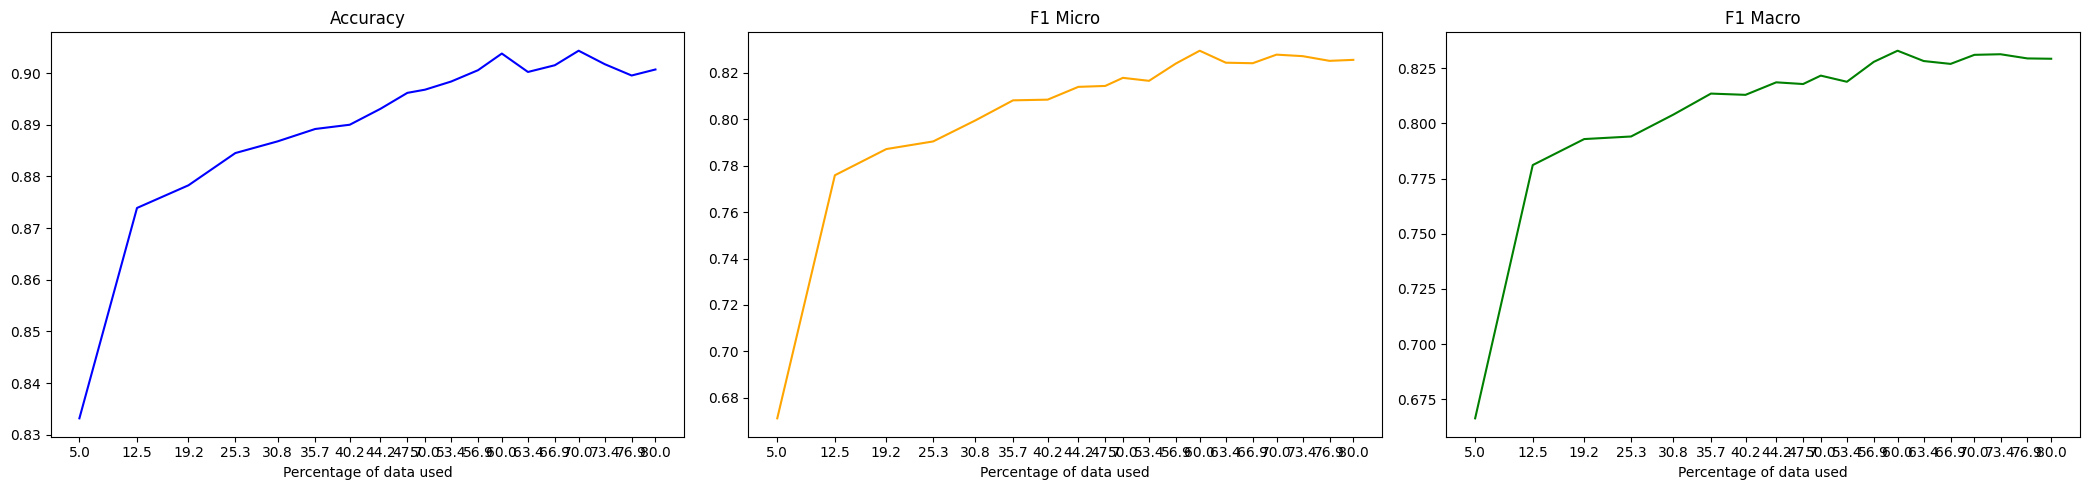

In [17]:
active_learning([50, 67, 42], 0)